# Periodogram Search for GRB 230307A Fermi BGO Data

First, let's use periodograms to explore the signal:

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

import numpy as np
import scipy.io
import pickle

import jax
# Important to enable 64-bit precision
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random
import tensorflow_probability.substrates.jax as tfp

from tinygp import GaussianProcess, kernels
from jaxns.utils import resample

import stingray
from stingray import Lightcurve, Powerspectrum
from stingray.modeling.gpmodeling import get_kernel, get_mean
from stingray.modeling.gpmodeling import get_prior, get_log_likelihood, get_gp_params

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# abbreviations for tensorflow distributions + bijectors
tfpd = tfp.distributions
tfpb = tfp.bijectors


INFO[2024-03-27 12:53:57,300]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
I0000 00:00:1711540437.300230       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
INFO[2024-03-27 12:53:57,301]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2024-03-27 12:53:57,308]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/grbsearch/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
/Users/daniela/work/repositories/stingraysoftware/stingray/stingray/utils.py:35: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn(

INFO[2024-03-27 12:54:09,909]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2024-03-27 12:54:10,012]: Checking if light curve is sorted.


{'b1_times': array([-138.53565357, -138.48565357, -138.43565357, ...,  475.76434643,
        475.81434643,  475.86434643], dtype='>f8'), 'b1_counts': array([50., 47., 37., ..., 46., 51., 14.], dtype='>f8'), 'bbtime': 699896631.1646451, 'tres': 0.05}


INFO[2024-03-27 12:54:10,113]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation
INFO[2024-03-27 12:54:10,339]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2024-03-27 12:54:10,340]: Checking if light curve is sorted.
INFO[2024-03-27 12:54:10,341]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


<IPython.core.display.Javascript object>


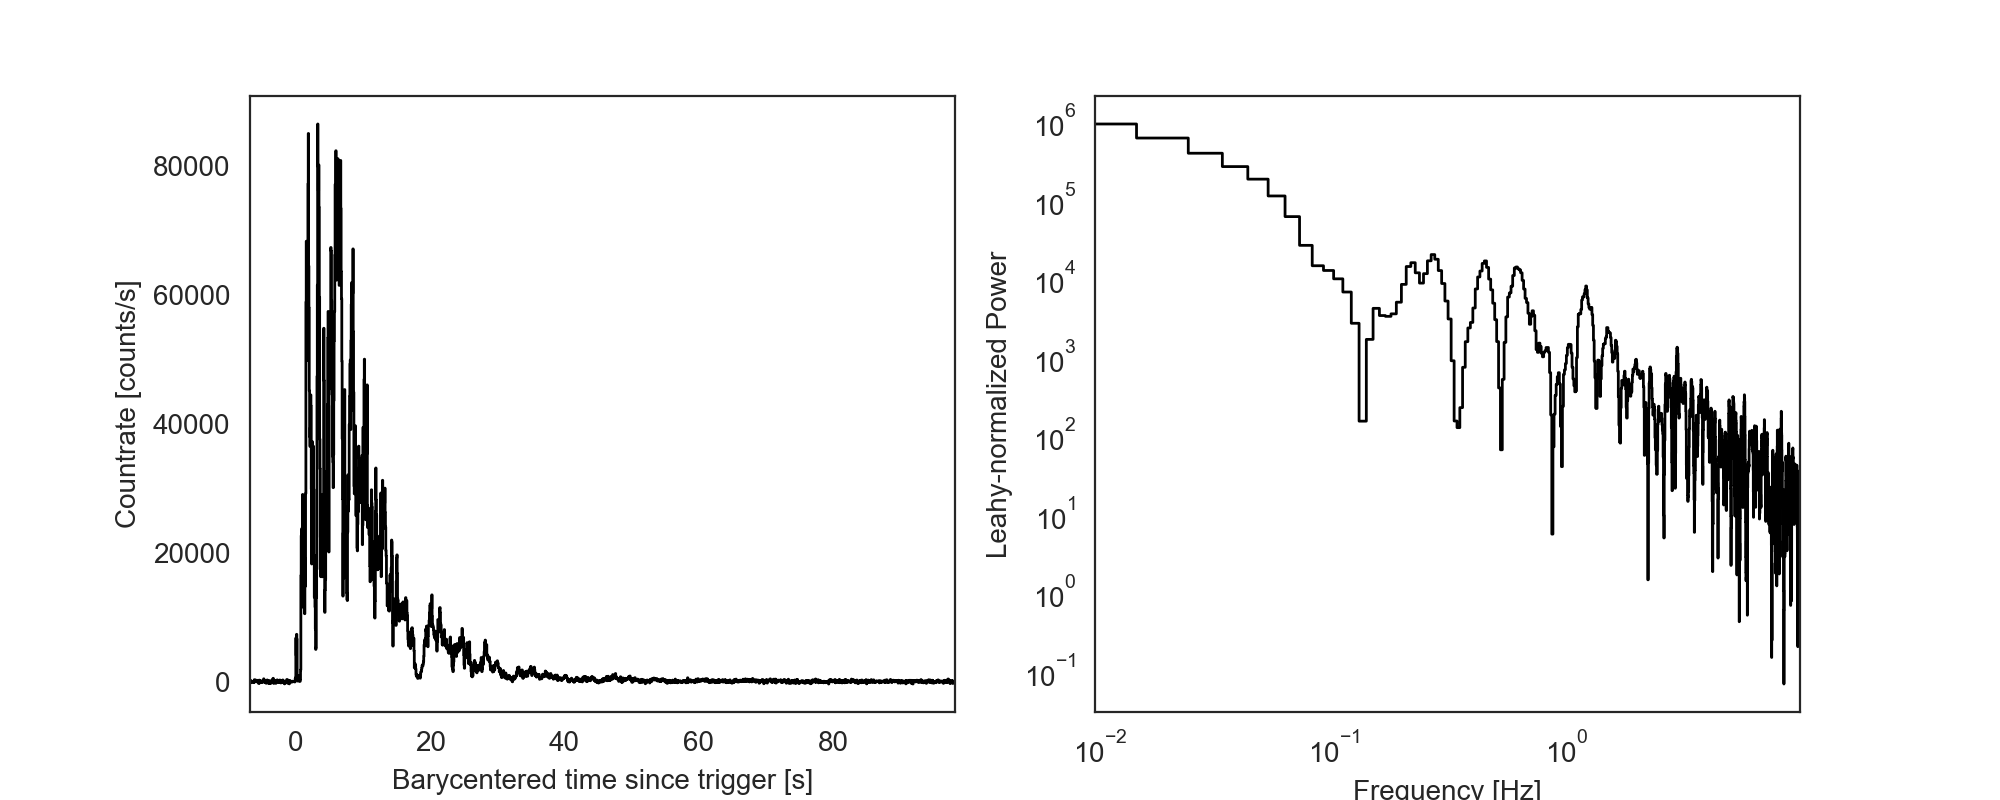

Text(0, 0.5, 'Leahy-normalized Power')

In [3]:
datadir = "../data/"
figdir = "../figures/"

# read data
data = scipy.io.readsav(datadir+"bn230307656_b1_lc_bary.sav")

print(data)
# extract events
barytime = np.array(data["b1_times"], dtype=float)
counts = np.array(data["b1_counts"], dtype=float)
#lc = Lightcurve.make_lightcurve(barytime, dt=0.05)
lc = Lightcurve(barytime, counts)

# truncate light curve
minind = lc.time.searchsorted(-6.871859666673766)
maxind = lc.time.searchsorted(98.12814033332624)
lc = lc.truncate(start=minind, stop=maxind, method="index")

# correct for dead time
deadtime = 2.6e-6 
frac_obs = deadtime/lc.dt * lc.counts
counts_obs_corr = lc.counts / (1. - frac_obs) 

# subtract mean background
mean_bkg = np.mean(counts_obs_corr[-100:])

# make light curve and PSD
lc = Lightcurve(lc.time, counts_obs_corr-mean_bkg)
ps = Powerspectrum(lc, norm="leahy")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc.time, lc.countrate, lw=1, color="black", ds="steps-mid")
ax1.set_xlim(lc.time[0], lc.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Countrate [counts/s]")

ax2.loglog(ps.freq, ps.power, ds="steps-mid", lw=1, color="black")
ax2.set_xlim(ps.freq[0], ps.freq[-1])
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy-normalized Power")

## Fitting a power law and looking for outliers

Let's fit a power law and simulate the highest outlier, which will not return anything useful, I don't thin

In [4]:
from stingray import Powerspectrum
from stingray.modeling import PSDPosterior, PSDParEst
from astropy.modeling import models
from stingray.modeling import set_logprior
import scipy.stats
from astropy.modeling.fitting import _fitter_to_model_params


In [5]:
# define power law component
pl = models.PowerLaw1D()

# fix x_0 of power law component
pl.x_0.fixed = True

# define constant
c = models.Const1D()

# make compound model
plc = pl + c

log-prior: 1.383646559789373
log-likelihood: -6481.73959528844
log-posterior: -6480.35594872865


<IPython.core.display.Javascript object>


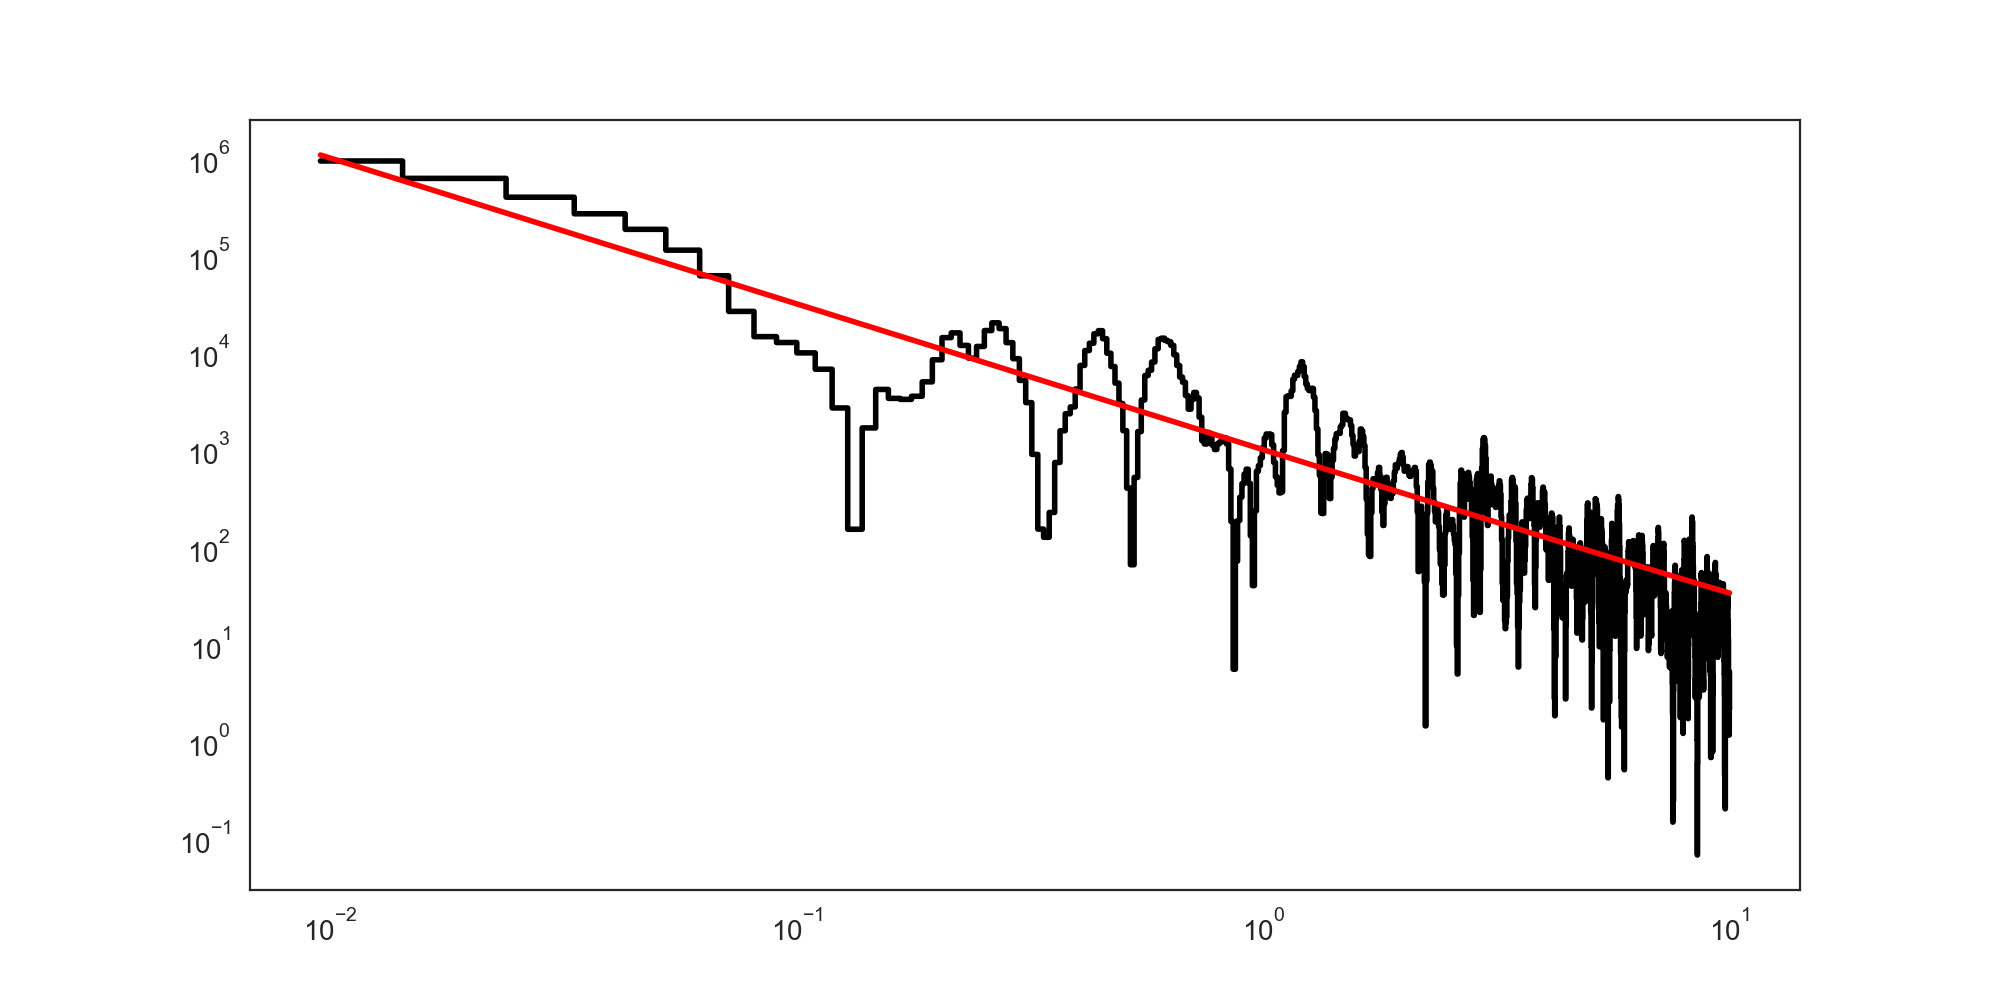

In [6]:
# flat prior for the power law index
p_alpha = lambda alpha: ((-1. <= alpha) & (alpha <= 5.))

# flat prior for the power law amplitude
p_amplitude = lambda amplitude: ((1 <= amplitude) & (amplitude <= 1e8))

# normal prior for the white noise parameter
p_whitenoise = lambda white_noise: scipy.stats.norm(2.0, 0.1).pdf(white_noise)

priors = {}
priors["alpha_0"] = p_alpha
priors["amplitude_0"] = p_amplitude
priors["amplitude_1"] = p_whitenoise

lpost = PSDPosterior(ps.freq, ps.power, plc, m=ps.m)
lpost.logprior = set_logprior(lpost, priors)

test_pars = [1e3, 1.5, 2.0]
print("log-prior: " + str(lpost.logprior(test_pars)))
print("log-likelihood: " + str(lpost.loglikelihood(test_pars)))
print("log-posterior: " + str(lpost(test_pars)))

_fitter_to_model_params(plc, test_pars)

fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.loglog(ps.freq, ps.power, lw=2, color="black", ds="steps-mid")
ax.plot(ps.freq, plc(ps.freq) , lw=2, color="red")

<IPython.core.display.Javascript object>


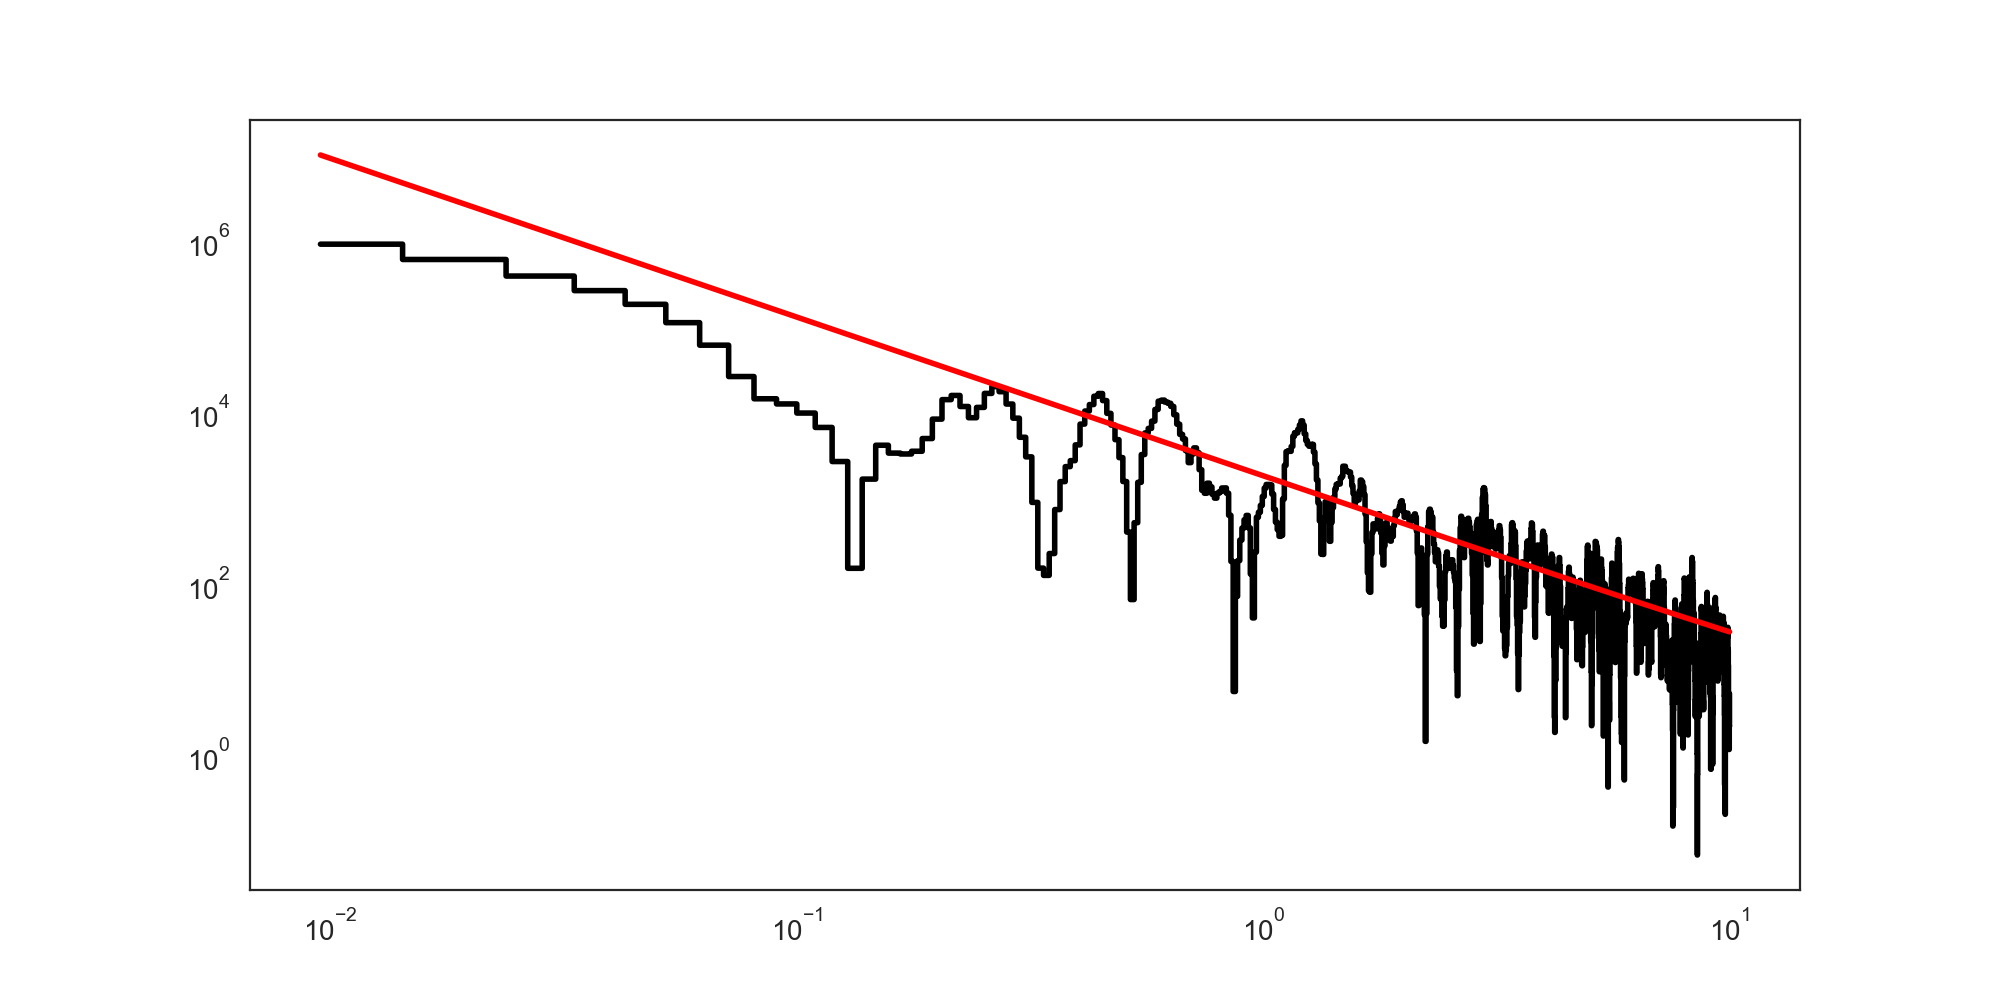

In [7]:
parest = PSDParEst(ps, fitmethod='l-bfgs-b', max_post=True)
res = parest.fit(lpost, test_pars)

fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.loglog(ps.freq, ps.power, lw=2, color="black", ds="steps-mid")
ax.plot(ps.freq, res.mfit, lw=2, color="red")

In [7]:
sample = parest.sample(lpost, res.p_opt, cov=res.cov, nwalkers=50,
             niter=1000, burnin=1000, namestr="")

Chains too short to compute autocorrelation lengths.
INFO[2024-03-21 09:38:03,716]: Chains too short to compute autocorrelation lengths.
-- The acceptance fraction is: 0.646360.5
INFO[2024-03-21 09:38:03,730]: -- The acceptance fraction is: 0.646360.5
R_hat for the parameters is: [1.16482415e+04 1.45566467e-03 9.79433605e-03]
INFO[2024-03-21 09:38:03,732]: R_hat for the parameters is: [1.16482415e+04 1.45566467e-03 9.79433605e-03]
-- Posterior Summary of Parameters: 

INFO[2024-03-21 09:38:03,734]: -- Posterior Summary of Parameters: 

parameter 	 mean 		 sd 		 5% 		 95% 

INFO[2024-03-21 09:38:03,735]: parameter 	 mean 		 sd 		 5% 		 95% 

---------------------------------------------

INFO[2024-03-21 09:38:03,737]: ---------------------------------------------

theta[0] 	 1846.9582835385593	109.00035505760522	1675.8923670689094	2033.4507777091612

INFO[2024-03-21 09:38:03,738]: theta[0] 	 1846.9582835385593	109.00035505760522	1675.8923670689094	2033.4507777091612

theta[1] 	 1.858257

In [8]:
post_samples = sample.samples

<IPython.core.display.Javascript object>


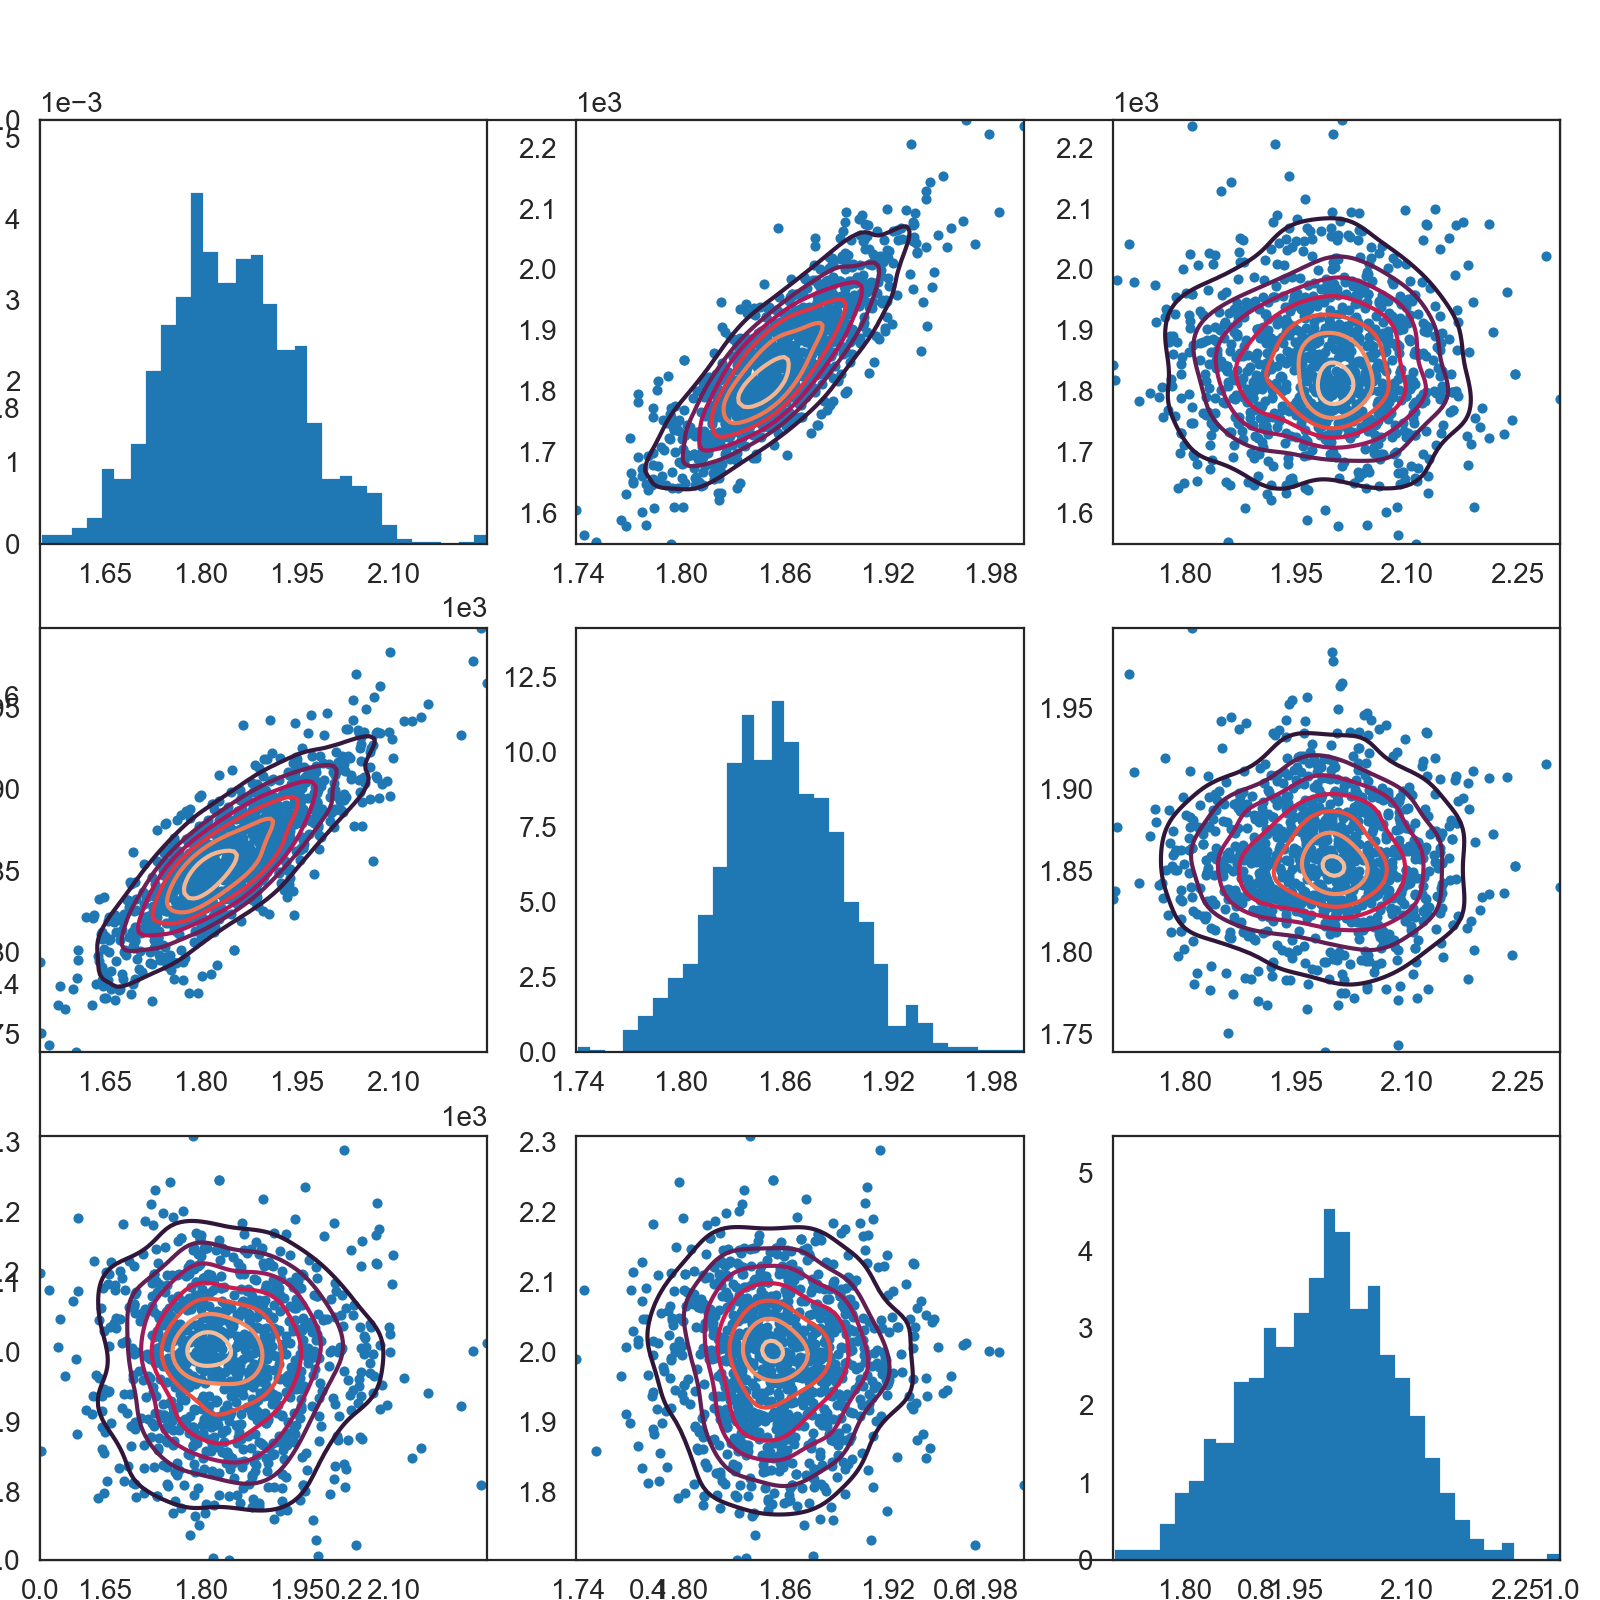

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
fig = sample.plot_results(nsamples=1000,save_plot=True, fig=fig,
                    filename=figdir+"grb230307a_fermi_bgo_corner.pdf")


Let's save the sample to file:

In [10]:
np.savetxt(datadir + "grb230307a_fermi_bgo_pl_sample.txt", sample.samples)

Here's how to load the samples:

In [8]:
post_samples = np.loadtxt(datadir + "grb230307a_fermi_bgo_pl_sample.txt")

<IPython.core.display.Javascript object>


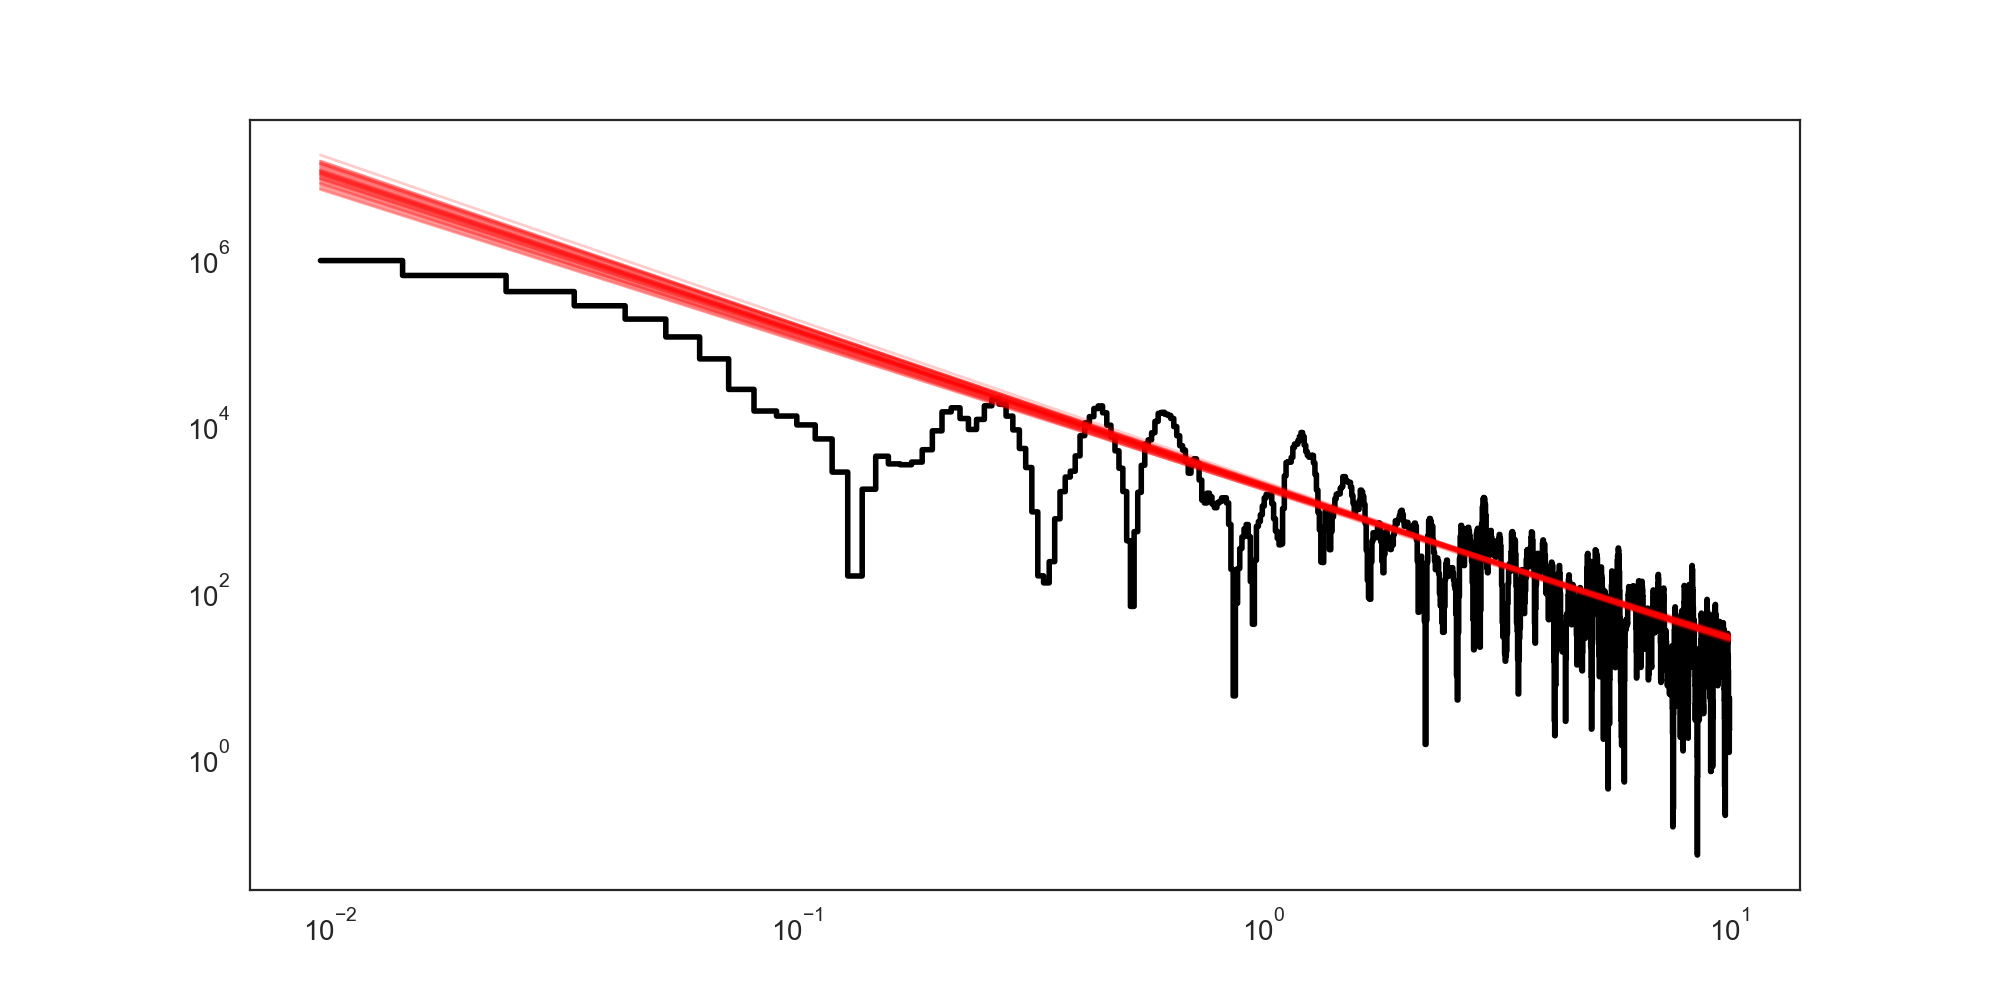

In [9]:
idx = np.random.choice(np.arange(post_samples.shape[0]), size=50, replace=False)


fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.loglog(ps.freq, ps.power, lw=2, color="black", ds="steps-mid")


for i in idx:
    _fitter_to_model_params(plc, post_samples[i])
    ax.plot(ps.freq, plc(ps.freq) , lw=1, color="red", alpha=0.2)

### Broken Powerlaw Model

Let's compare this to a broken power law model, I think the power law is overestimating the lowest frequencies;

In [13]:
# broken power law model
bpl = models.BrokenPowerLaw1D()

# add constant
bplc = bpl + c

# flat prior for the power law indices
p_alpha1 = lambda alpha: ((-1. <= alpha) & (alpha <= 5.))
p_alpha2 = lambda alpha: ((-1. <= alpha) & (alpha <= 5.))

# flat prior for the break frequency
p_x_break = lambda xbreak: ((0.01 <= xbreak) & (10.0 >= xbreak))

# flat prior for the power law amplitude
p_amplitude = lambda amplitude: ((1 <= amplitude) & (amplitude <= 1e8))

# normal prior for the white noise parameter
p_whitenoise = lambda white_noise: scipy.stats.norm(2.0, 0.1).pdf(white_noise)


priors_bpl = {}
priors_bpl["alpha_1_0"] = p_alpha
priors_bpl["alpha_2_0"] = p_alpha

priors_bpl["amplitude_0"] = p_amplitude
priors_bpl["amplitude_1"] = p_whitenoise
priors_bpl["x_break_0"] = p_x_break

Likelihood ratio: 4.554009111250707


<IPython.core.display.Javascript object>


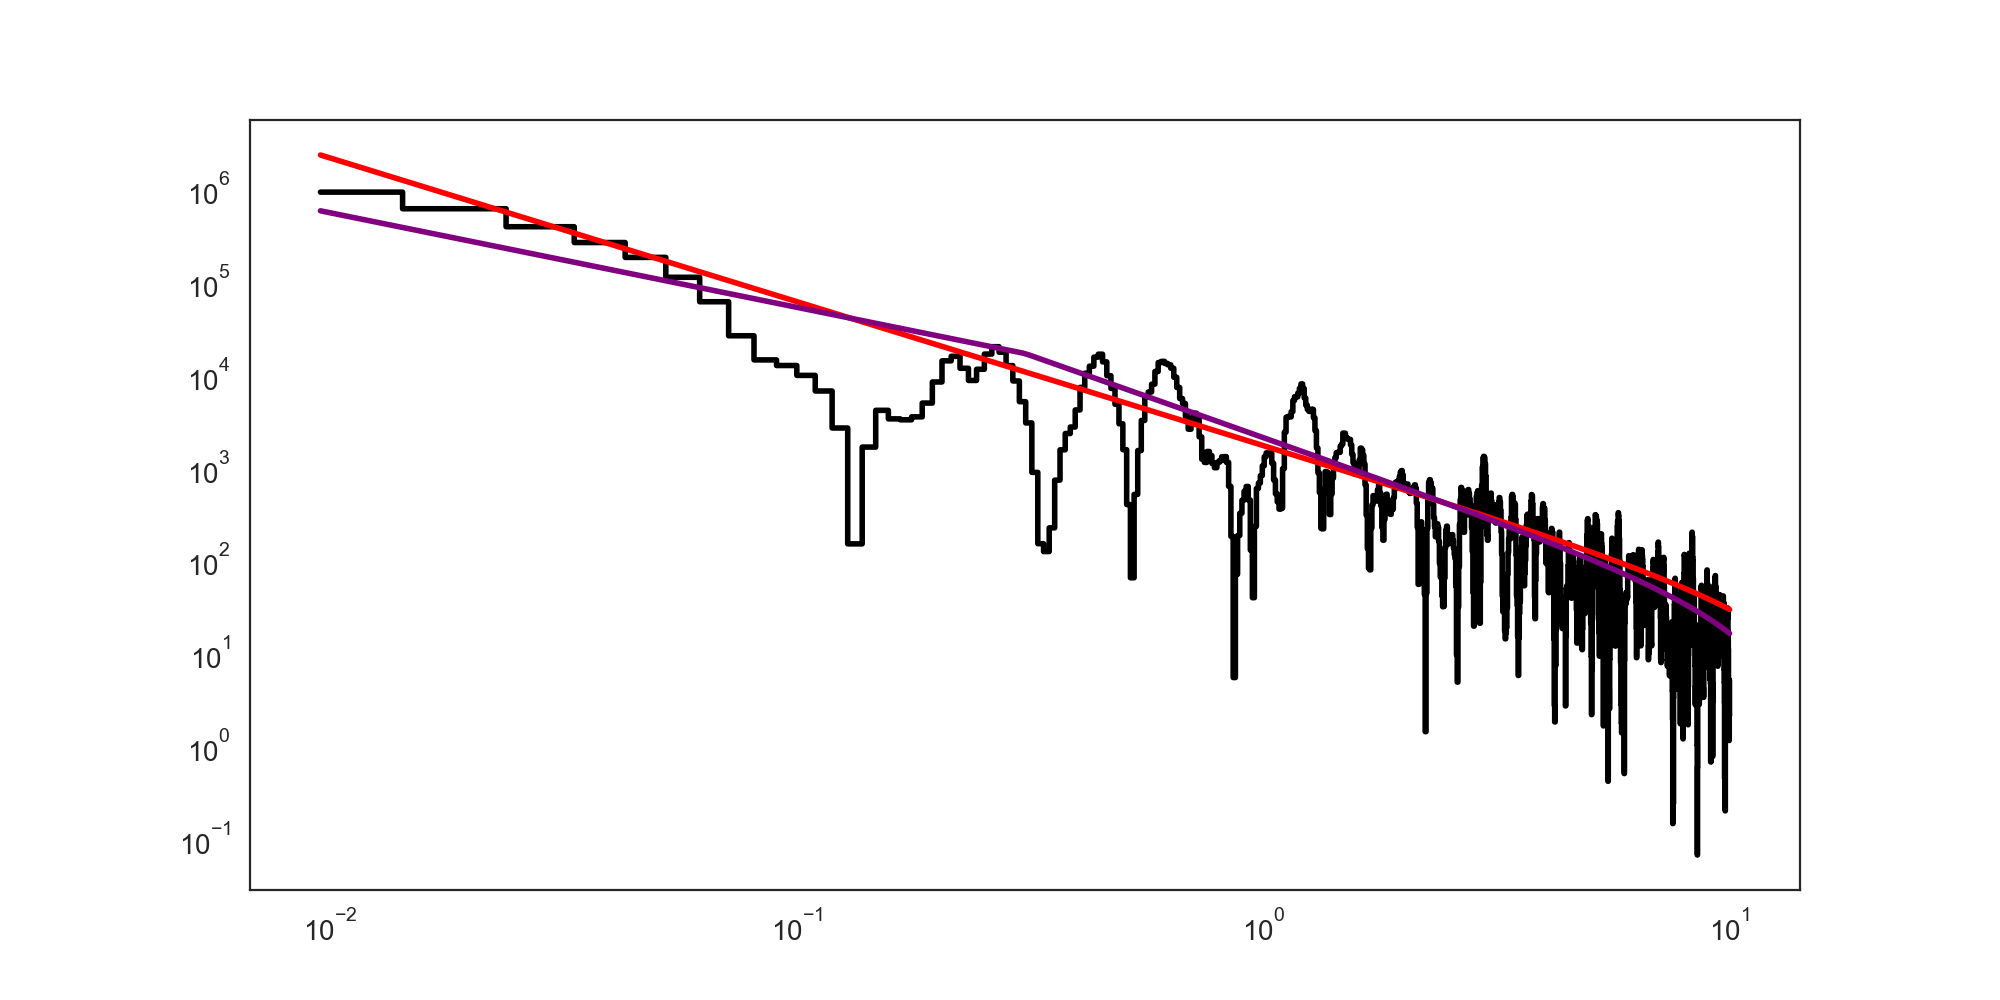

In [14]:
lpost_bplc = PSDPosterior(ps.freq, ps.power, bplc, priors=priors_bpl, m=ps.m)

parest = PSDParEst(ps, fitmethod='powell', max_post=False)
test_pars_bplc = [4e6, 0.05, 0.5, 1.7, 2.0]

lrt, plc_opt, bplc_opt = parest.compute_lrt(lpost, test_pars, lpost_bplc, test_pars_bplc)

print(f"Likelihood ratio: {lrt}")
_fitter_to_model_params(plc, plc_opt.p_opt)
_fitter_to_model_params(bplc, bplc_opt.p_opt)

fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.loglog(ps.freq, ps.power, lw=2, color="black", ds="steps-mid")
ax.plot(ps.freq, plc(ps.freq) , lw=2, color="red")
ax.plot(ps.freq, bplc(ps.freq) , lw=2, color="purple")

In [15]:
nsim = 1000
idx = np.random.choice(np.arange(sample.samples.shape[0]), size=nsim, replace=False)
s_all = sample.samples[idx,:]

In [16]:
lrt_sim = parest.simulate_lrts(s_all, lpost, test_pars,
                     lpost_bplc, test_pars_bplc)

In [17]:
np.savetxt(datadir + "grb230307a_fermi_bgo_pl_bpl_lrt.txt", lrt_sim)

<IPython.core.display.Javascript object>


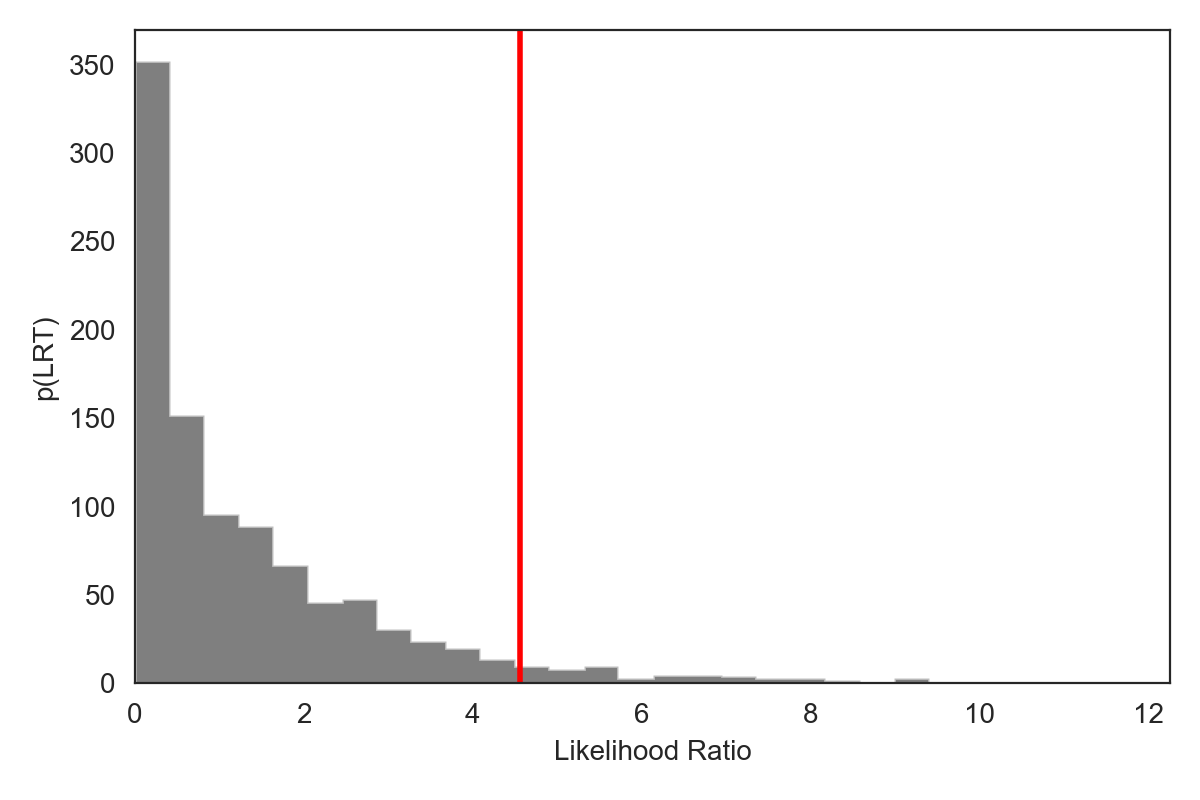

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.hist(lrt_sim, bins=30, histtype="stepfilled", alpha=0.5, color="black")

ax.axvline(lrt, lw=2, color="red")
ax.set_xlim(np.min(lrt_sim), np.max(lrt_sim))
ax.set_xlabel("Likelihood Ratio")
ax.set_ylabel("p(LRT)")
fig.tight_layout()
fig.savefig(figdir + "grb230307a_fermi_bgo_pl_bpl_lrt.pdf", format="pdf")

In [19]:
np.sum(lrt_sim > lrt)/len(lrt_sim)

0.059

Meh, that's not really evidence for the presence of bent power law. Ok, let's simulate some power laws:

### Computing the highest outlier of the spectrum 

Let's compute the highest outlier and calibrate that:

In [20]:
t_sim = parest.simulate_highest_outlier(s_all, lpost, test_pars)

In [21]:
np.savetxt(datadir + "grb230307a_fermi_bgo_pl_tsim_lrt.txt", t_sim)

<IPython.core.display.Javascript object>


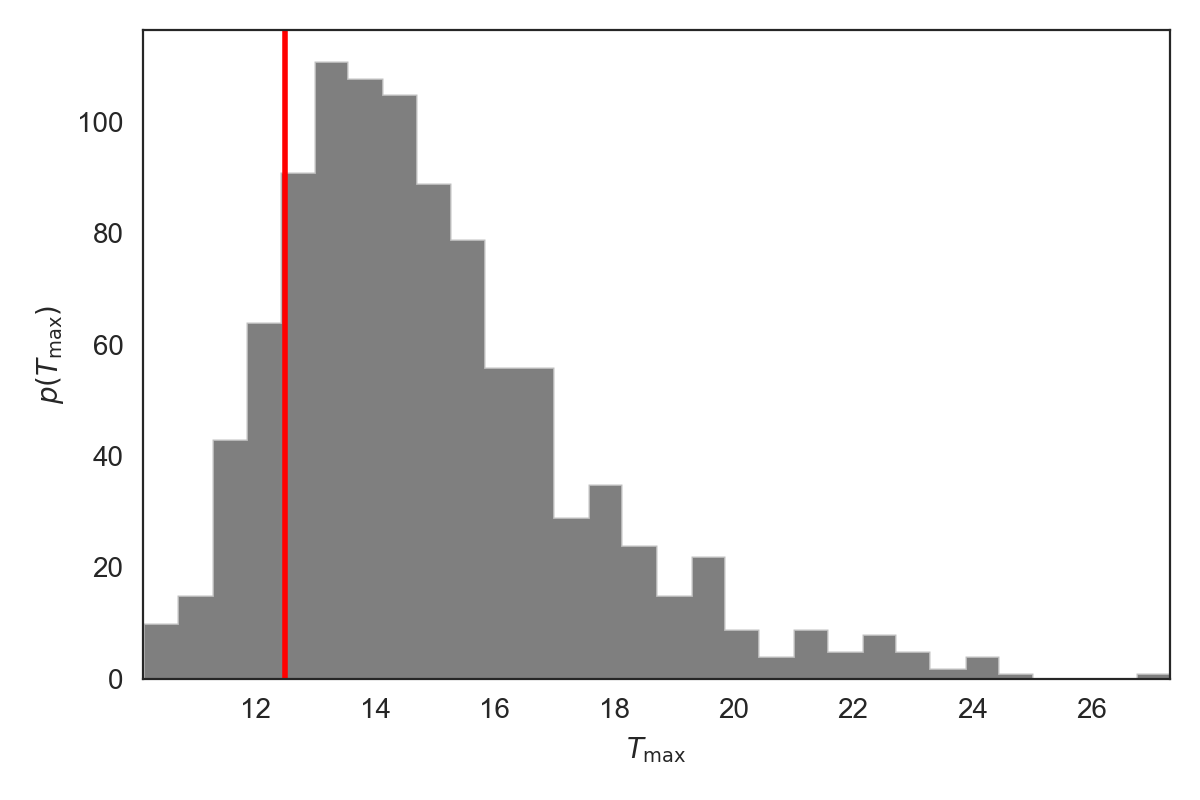

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.hist(t_sim, bins=30, histtype="stepfilled", alpha=0.5, color="black")

ax.axvline(res.maxpow, lw=2, color="red")
ax.set_xlim(np.min(t_sim), np.max(t_sim))
ax.set_xlabel(r"$T_{\mathrm{max}}$")
ax.set_ylabel(r"$p(T_{\mathrm{max}})$")
fig.tight_layout()
fig.savefig(figdir + "grb230307a_fermi_bgo_pl_maxpost.pdf", format="pdf")

In [23]:
np.sum(t_sim > res.maxpow)/len(t_sim)

0.846

Okay, that's not super significant. What about a Lorentzian model comparison?

In [10]:
# broken power law model
qpoplc = models.PowerLaw1D() + models.Lorentz1D()

# fix x_0 of power law component
qpoplc.x_0_0.fixed = True

# flat prior for the power law indices
p_alpha0 = lambda alpha: ((-1. <= alpha) & (alpha <= 5.))

# flat prior for the power law amplitude
p_amplitude = lambda amplitude: ((1 <= amplitude) & (amplitude <= 1e8))

p_x0 = lambda x0: ((0.1 <= x0) & (x0 <= 2.5))
p_fwhm = lambda fwhm: ((0.001 <= fwhm) & (fwhm <= 1.0))

# normal prior for the white noise parameter
p_whitenoise = lambda white_noise: scipy.stats.norm(2.0, 0.1).pdf(white_noise)

priors_qpopl = {"amplitude_0": p_amplitude,
                "alpha_0": p_alpha0,
                "amplitude_1": p_amplitude,
                "x_0_1": p_x0,
                "fwhm_1": p_fwhm
               }

[ 1.50075783e+03  1.74157582e+00  5.99480026e+03  1.21126779e+00
 -8.48986696e-02]
Likelihood ratio: 23.00955539817005


<IPython.core.display.Javascript object>


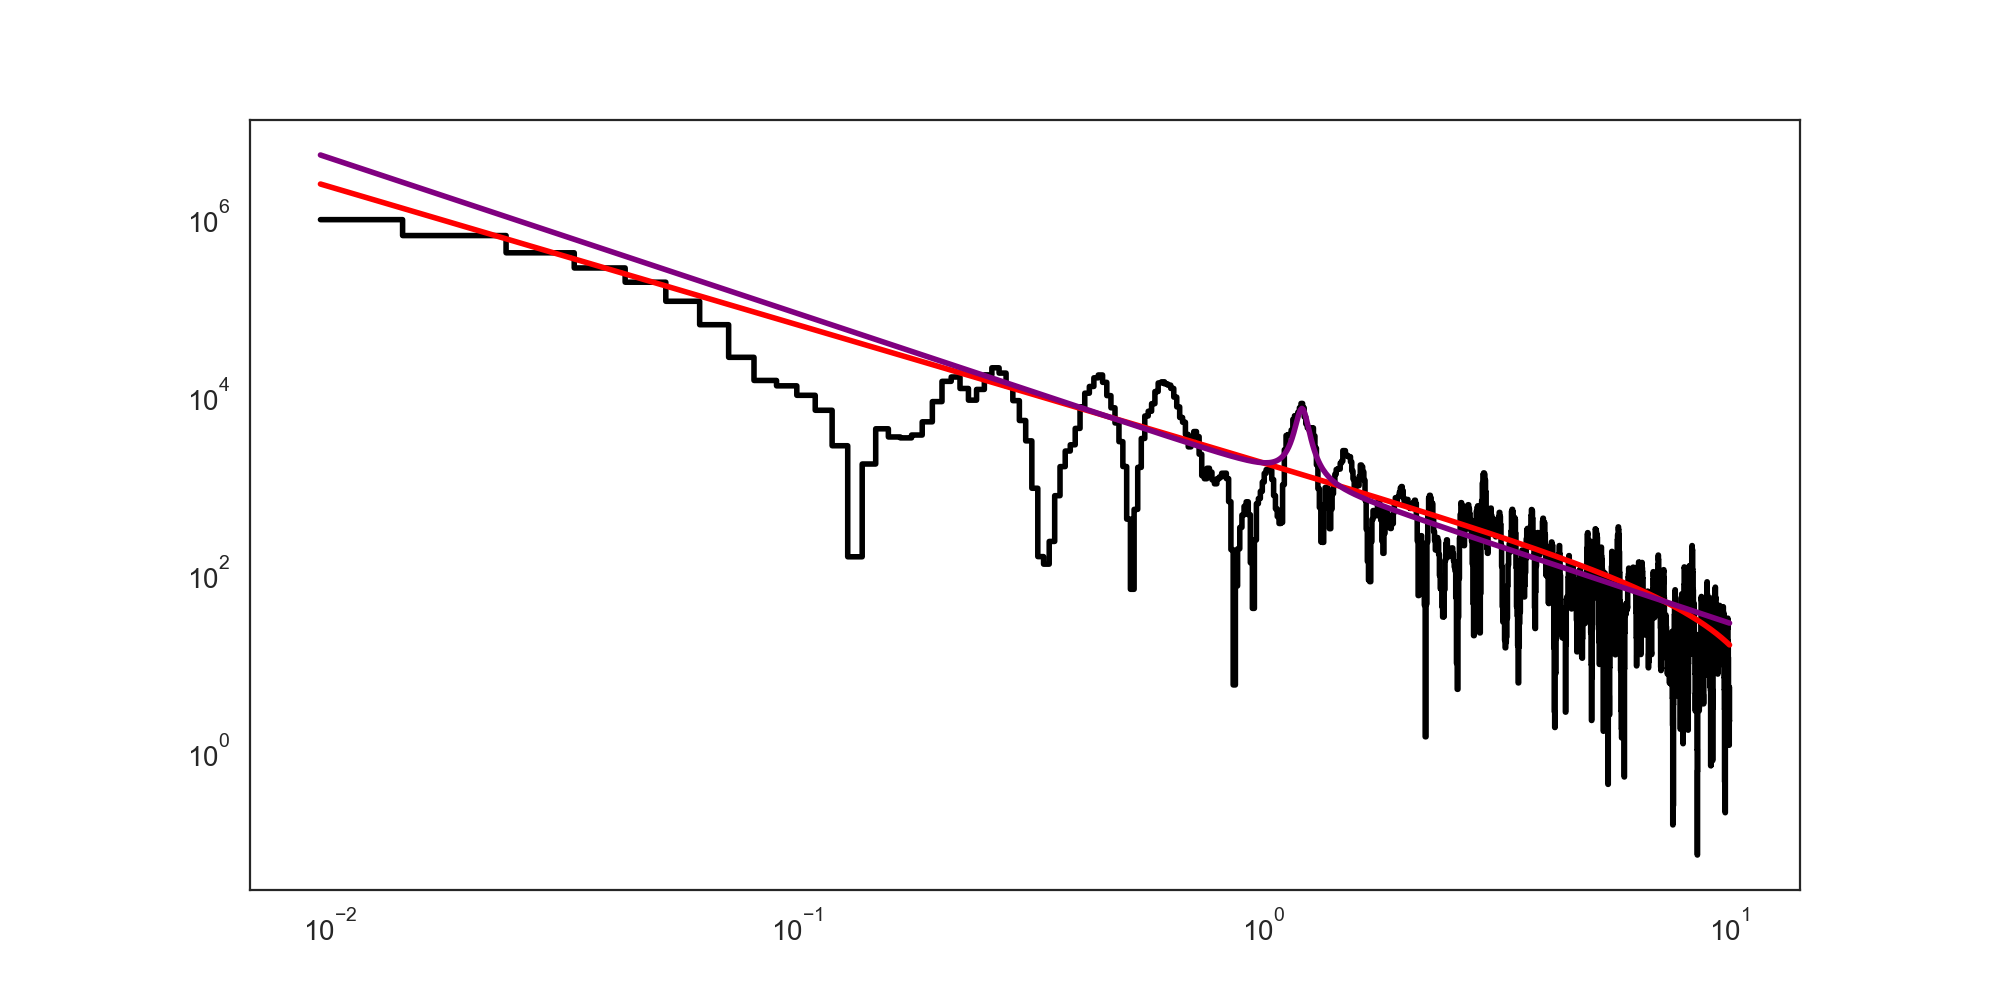

In [11]:
lpost_qpoplc = PSDPosterior(ps.freq, ps.power, qpoplc, priors=priors_qpopl, m=ps.m)

parest = PSDParEst(ps, fitmethod='l-bfgs-b', max_post=False)
test_pars_qpoplc = [1500, 1.7, 6000, 1.2, 0.005]

lrt, plc_opt, qpoplc_opt = parest.compute_lrt(lpost, test_pars, lpost_qpoplc, test_pars_qpoplc)
print(qpoplc_opt.p_opt)
print(f"Likelihood ratio: {lrt}")

_fitter_to_model_params(plc, plc_opt.p_opt)
_fitter_to_model_params(qpoplc, qpoplc_opt.p_opt)

fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.loglog(ps.freq, ps.power, lw=2, color="black", ds="steps-mid")
ax.plot(ps.freq, plc(ps.freq) , lw=2, color="red")
ax.plot(ps.freq, qpoplc(ps.freq) , lw=2, color="purple")

Let's run a model comparison:

In [27]:
lrt_sim_qpo = parest.simulate_lrts(s_all, lpost, test_pars,
                     lpost_qpoplc, test_pars_qpoplc)

In [28]:
np.savetxt(datadir + "grb230307a_fermi_bgo_qpo_tsim_lrt.txt", lrt_sim)

In [31]:
np.min(lrt_sim_qpo)

-86023.67896810675

<IPython.core.display.Javascript object>


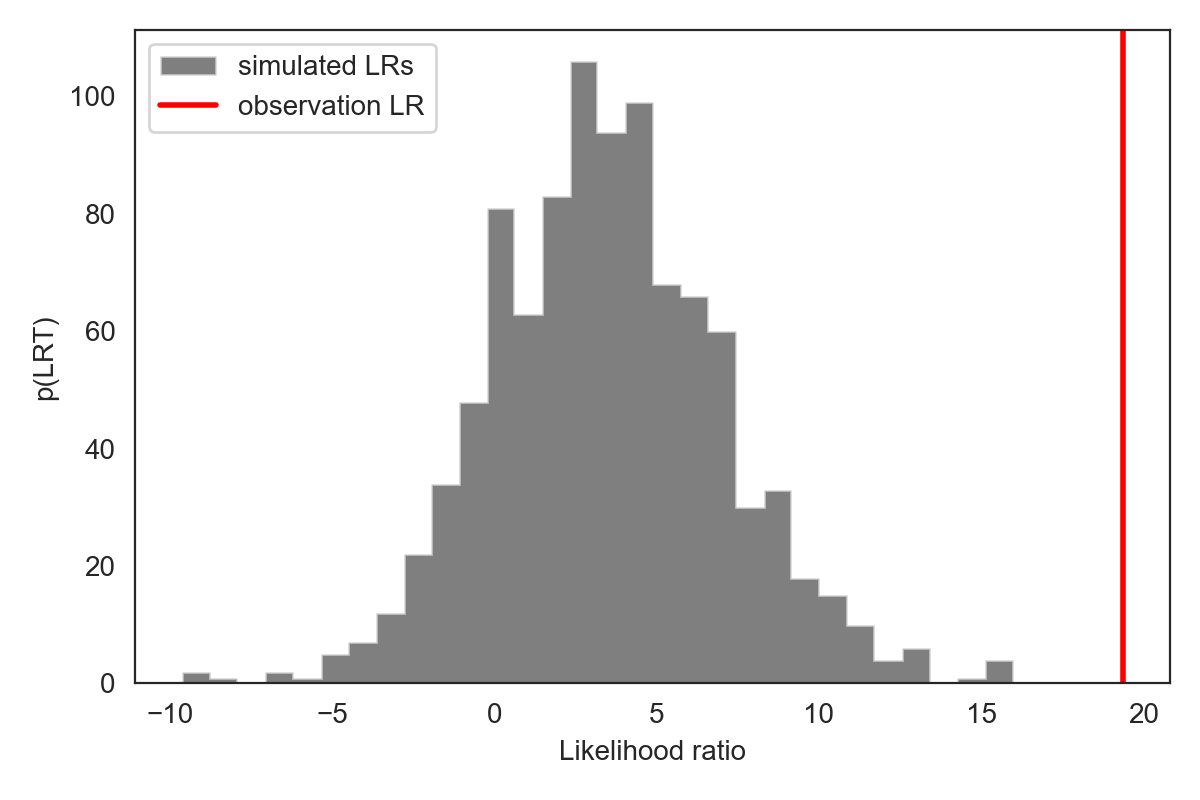

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.hist(lrt_sim_qpo[lrt_sim_qpo > -50000], bins=30, histtype="stepfilled", alpha=0.5, color="black", label="simulated LRs")

ax.axvline(lrt, lw=2, color="red", label="observation LR")
#ax.set_xlim(np.min(lrt_sim_qpo), np.max(lrt_sim_qpo))
ax.set_xlabel("Likelihood ratio")
ax.set_ylabel("p(LRT)")
ax.legend()
fig.tight_layout()
fig.savefig(figdir + "grb230307a_fermi_bgo_pl_qpopl_lrt.pdf", format="pdf")

Okay, so that's *very* significant. But is it *meaningful*? That's the question.

### MCMC on QPO Model

In [48]:
qpoplc_opt.p_opt

array([ 1.45838538e+03,  1.72654249e+00,  6.27218456e+03,  1.21175440e+00,
       -8.50074537e-02])

In [15]:
sample = parest.sample(lpost_qpoplc, qpoplc_opt.p_opt, cov=qpoplc_opt.cov/40, nwalkers=100,
             niter=1000, burnin=1000, namestr="")

Chains too short to compute autocorrelation lengths.
INFO[2024-03-25 14:05:24,311]: Chains too short to compute autocorrelation lengths.
-- The acceptance fraction is: 0.452780.5
INFO[2024-03-25 14:05:24,358]: -- The acceptance fraction is: 0.452780.5
R_hat for the parameters is: [9.39102951e+03 1.54592947e-03 1.42288779e+08 2.82681288e-04
 2.81134889e-03]
INFO[2024-03-25 14:05:24,359]: R_hat for the parameters is: [9.39102951e+03 1.54592947e-03 1.42288779e+08 2.82681288e-04
 2.81134889e-03]
-- Posterior Summary of Parameters: 

INFO[2024-03-25 14:05:24,361]: -- Posterior Summary of Parameters: 

parameter 	 mean 		 sd 		 5% 		 95% 

INFO[2024-03-25 14:05:24,362]: parameter 	 mean 		 sd 		 5% 		 95% 

---------------------------------------------

INFO[2024-03-25 14:05:24,364]: ---------------------------------------------

theta[0] 	 1462.6601292915825	97.38941058685172	1305.398882759722	1623.8056770145743

INFO[2024-03-25 14:05:24,365]: theta[0] 	 1462.6601292915825	97.38941058685172

In [16]:
np.savetxt(datadir + "grb230307a_fermi_bgo_qpopl_sample.txt", sample.samples)

Loading the QPO+PL MCMC sample:

In [12]:
post_samples_qpo = np.loadtxt(datadir + "grb230307a_fermi_bgo_qpopl_sample.txt")

### Model Comparison 1 QPO vs 2 QPO Model

[1.37324390e+03 1.71210175e+00 6.01338064e+03 1.21233003e+00
 9.15406190e-02 5.00287249e+03 2.97747445e+00 1.77812630e-02]
Likelihood ratio: 32.627221250622824


<IPython.core.display.Javascript object>


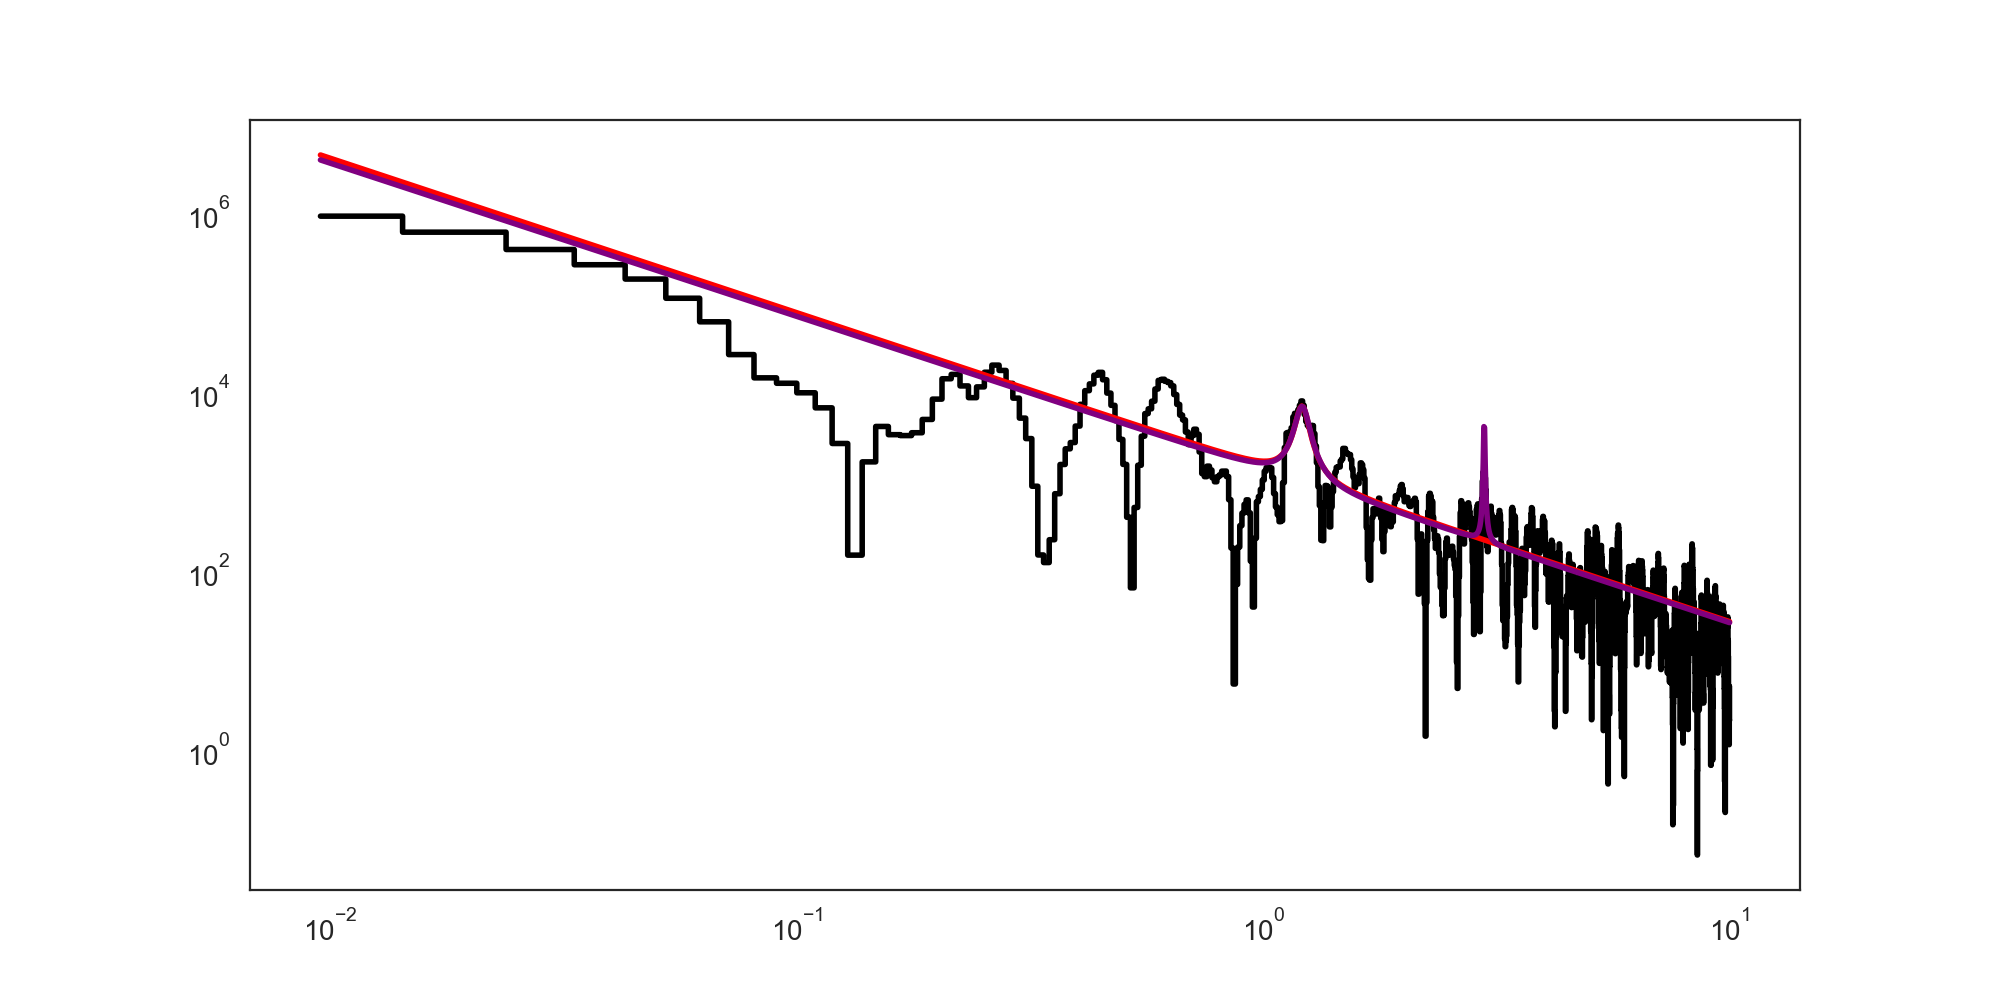

In [24]:
# broken power law model
two_qpoplc = models.PowerLaw1D() + models.Lorentz1D() + models.Lorentz1D()

# fix x_0 of power law component
two_qpoplc.x_0_0.fixed = True

# flat prior for the power law indices
p_alpha0 = lambda alpha: ((-1. <= alpha) & (alpha <= 5.))

# flat prior for the power law amplitude
p_amplitude = lambda amplitude: ((1 <= amplitude) & (amplitude <= 1e8))

p_x0_1 = lambda x0: ((0.1 <= x0) & (x0 <= 2.0))
p_x0_2 = lambda x0: ((2.0 <= x0) & (x0 <= 5.0))

p_fwhm_1 = lambda fwhm: ((0.001 <= fwhm) & (fwhm <= 1.0))
p_fwhm_2 = lambda fwhm: ((0.01 <= fwhm) & (fwhm <= 2.5))


priors_two_qpopl = {"amplitude_0": p_amplitude,
                "alpha_0": p_alpha0,
                "amplitude_1": p_amplitude,
                "x_0_1": p_x0_1,
                "fwhm_1": p_fwhm_1,
                'amplitude_2':p_amplitude,
                'x_0_2':p_x0_2,
                'fwhm_2':p_fwhm_2
                }

lpost_twoqpoplc = PSDPosterior(ps.freq, ps.power, two_qpoplc, priors=priors_two_qpopl, m=ps.m)

parest = PSDParEst(ps, fitmethod='bfgs', max_post=False)

test_pars_two_qpoplc = [1458, 1.72, 6016, 1.21, 0.087, 5000, 2.9, 0.01]

lrt_twoqpo, qpoplc_opt, two_qpoplc_opt = parest.compute_lrt(lpost_qpoplc, test_pars_qpoplc, lpost_twoqpoplc, test_pars_two_qpoplc)
print(two_qpoplc_opt.p_opt)
print(f"Likelihood ratio: {lrt_twoqpo}")
_fitter_to_model_params(qpoplc, qpoplc_opt.p_opt)
_fitter_to_model_params(two_qpoplc, two_qpoplc_opt.p_opt)

fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.loglog(ps.freq, ps.power, lw=2, color="black", ds="steps-mid")
ax.plot(ps.freq, qpoplc(ps.freq) , lw=2, color="red")
ax.plot(ps.freq, two_qpoplc(ps.freq) , lw=2, color="purple")

In [25]:
nsim = 1000
idx = np.random.choice(np.arange(post_samples_qpo.shape[0]), size=nsim, replace=False)
s_all_qpo = post_samples_qpo[idx,:]

lrt_sim_twoqpo = parest.simulate_lrts(s_all_qpo, lpost_qpoplc, test_pars_qpoplc,
                     lpost_twoqpoplc, test_pars_two_qpoplc)

In [26]:
np.savetxt(datadir + "grb230307a_fermi_bgo_twoqpo_tsim_lrt.txt", lrt_sim_twoqpo)

<IPython.core.display.Javascript object>


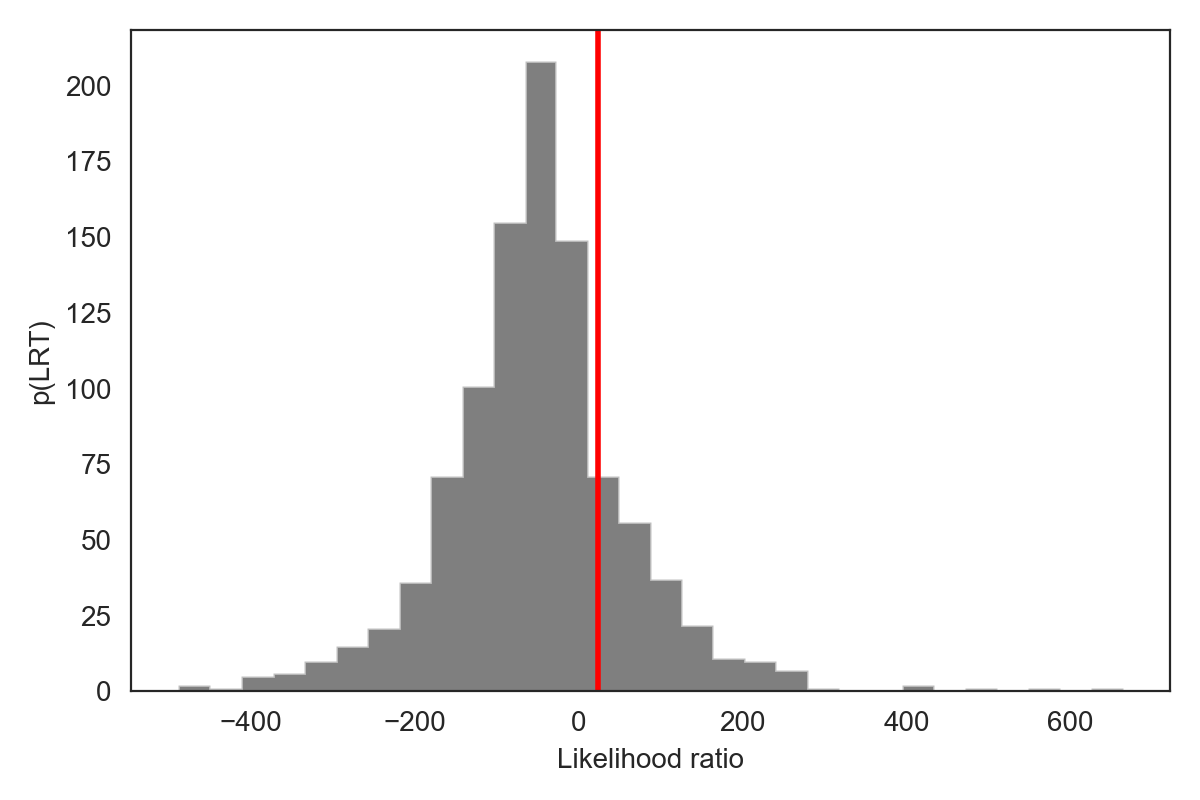

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.hist(lrt_sim_twoqpo, bins=30, histtype="stepfilled", alpha=0.5, color="black")

ax.axvline(lrt, lw=2, color="red")
#ax.set_xlim(np.min(lrt_sim_qpo), np.max(lrt_sim_qpo))
ax.set_xlabel("Likelihood ratio")
ax.set_ylabel("p(LRT)")
fig.tight_layout()
fig.savefig(figdir + "grb230307a_fermi_bgo_twoqpopl_lrt.pdf", format="pdf")

In [28]:
np.sum((lrt_sim_twoqpo > lrt))/nsim

0.199

In [29]:
sample = parest.sample(lpost_twoqpoplc, two_qpoplc_opt.p_opt, cov=two_qpoplc_opt.cov/30, nwalkers=100,
             niter=1000, burnin=1000, namestr="")

Chains too short to compute autocorrelation lengths.
INFO[2024-03-27 13:08:38,444]: Chains too short to compute autocorrelation lengths.
-- The acceptance fraction is: 0.300580.5
INFO[2024-03-27 13:08:38,493]: -- The acceptance fraction is: 0.300580.5
R_hat for the parameters is: [9.37548027e+03 1.42611151e-03 4.23040622e+07 2.72158277e-04
 3.09573156e-03 2.63180570e+06 8.90473851e-04 2.06232453e-02]
INFO[2024-03-27 13:08:38,495]: R_hat for the parameters is: [9.37548027e+03 1.42611151e-03 4.23040622e+07 2.72158277e-04
 3.09573156e-03 2.63180570e+06 8.90473851e-04 2.06232453e-02]
-- Posterior Summary of Parameters: 

INFO[2024-03-27 13:08:38,497]: -- Posterior Summary of Parameters: 

parameter 	 mean 		 sd 		 5% 		 95% 

INFO[2024-03-27 13:08:38,498]: parameter 	 mean 		 sd 		 5% 		 95% 

---------------------------------------------

INFO[2024-03-27 13:08:38,499]: ---------------------------------------------

theta[0] 	 1337.4998684211796	97.3118527141272	1179.3681259743043	1500.602

In [30]:
np.savetxt(datadir + "grb230307a_fermi_bgo_twoqpopl_sample.txt", sample.samples)

## Simulating light curves with power-law spectra

**I probably don't need to do this for the NaI and BGO data to prove my point**

In [67]:
from stingray.simulator.simulator import Simulator

In [75]:
lc.dt

0.04999971389770508

Time resolution of the simulated light curves: 0.04999971389770508
Number of time bins in the simulated light curves: 2101
Mean number of counts per bin in the simulated light curves: 11781.493574488339


<IPython.core.display.Javascript object>


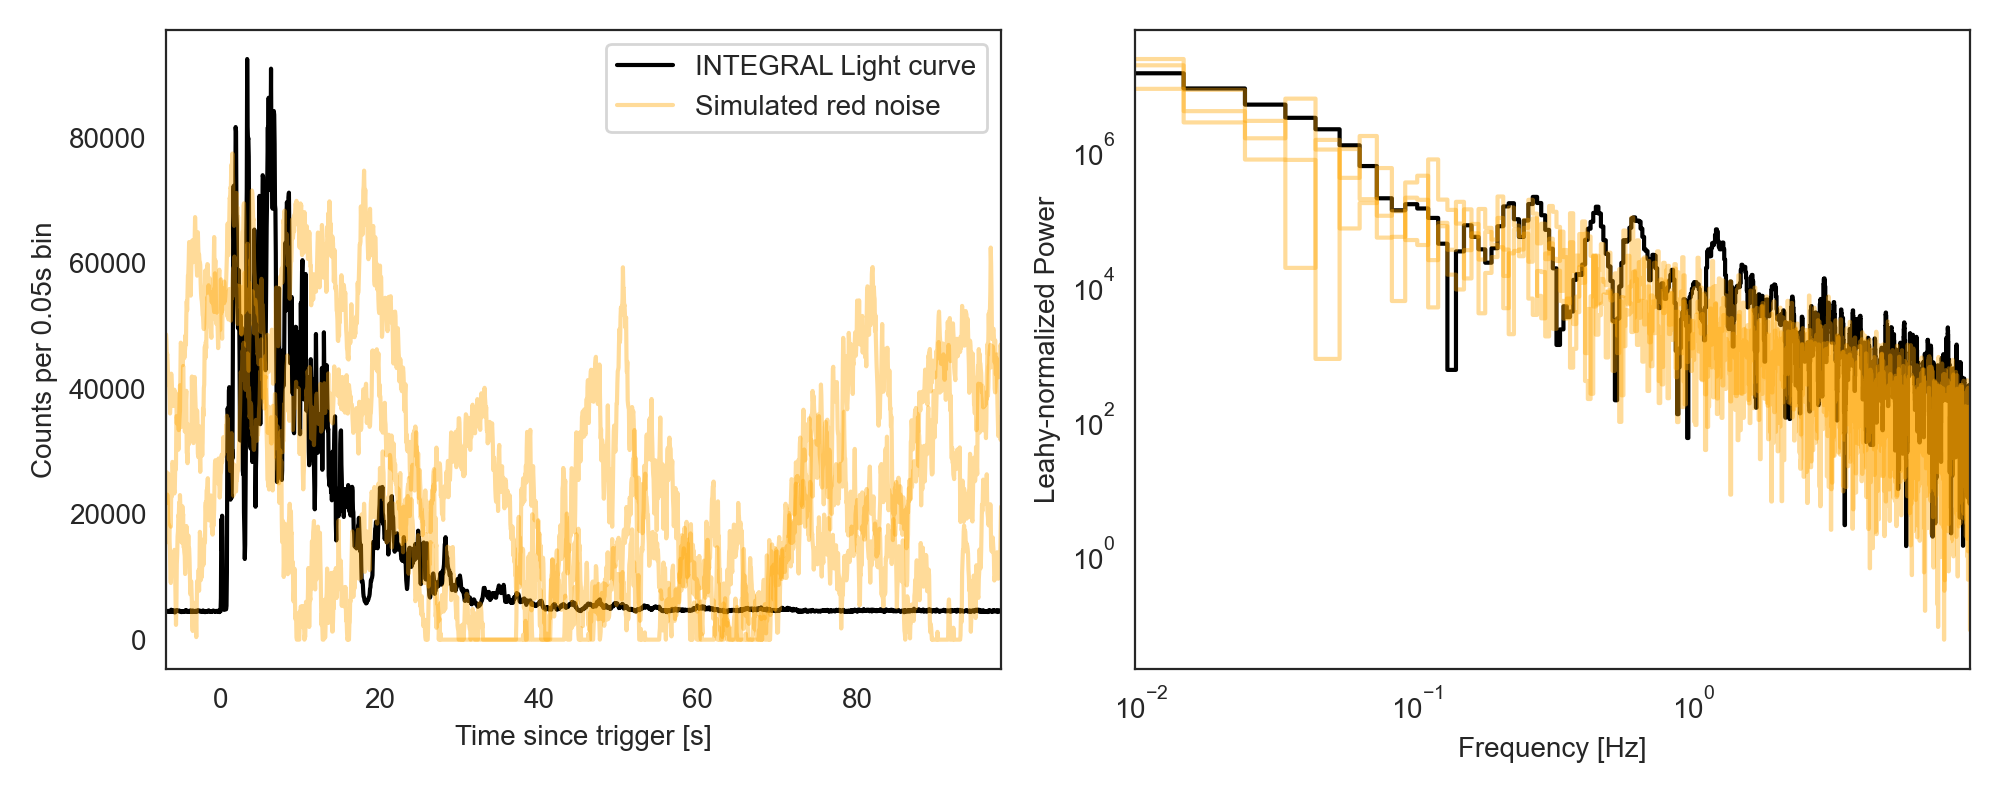

In [78]:
dt = lc.dt
print("Time resolution of the simulated light curves: " + str(dt))

nbins = int(lc.tseg/lc.dt)
print("Number of time bins in the simulated light curves: " + str(nbins))

mean_counts = np.mean(lc.counts)
print("Mean number of counts per bin in the simulated light curves: " + str(mean_counts))

sim = Simulator(dt=dt, N=nbins, mean=mean_counts+10000, rms=0.9, tstart = lc.time[0])

# exponential version
#sim = Simulator(dt=dt, N=nbins, mean=np.log(mean_counts), rms=0.1, tstart = lc.time[0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc.time, lc.counts, color="black", label="INTEGRAL Light curve")
ax2.loglog(ps.freq, ps.power, ds="steps-mid", color="black")


nsims = 1000
idx = np.random.choice(np.arange(sample.samples.shape[0]), size=nsims, replace=False)

for i in idx[:3]:
    _fitter_to_model_params(plc, sample.samples[i])

    pl_model = plc(ps.freq)
    lc_sim = sim.simulate(pl_model)
    
    # non-exponential version:
    lc_sim.counts[lc_sim.counts < 0] = 0.0
    counts = np.random.poisson(lc_sim.counts)
    
    # exponential version
    #counts = np.random.poisson(np.exp(lc_sim.counts))
    
    lc_sim = Lightcurve(lc_sim.time, counts, dt=lc_sim.dt, skip_checks=True)
    ps_sim = Powerspectrum(lc_sim, norm="leahy")
    
    if i == idx[0]:
        ax1.plot(lc_sim.time, lc_sim.counts, color="orange", alpha=0.4, label="Simulated red noise")
        ax2.loglog(ps_sim.freq, ps_sim.power, ds="steps-mid", color="orange", alpha=0.4)

    else:
        ax1.plot(lc_sim.time, lc_sim.counts, color="orange", alpha=0.4)
        ax2.loglog(ps_sim.freq, ps_sim.power, ds="steps-mid", color="orange", alpha=0.4)

ax1.legend()
ax1.set_xlim(lc.time[0], lc.time[-1])
ax2.set_xlim(ps.freq[0], ps.freq[-1])

ax1.set_xlabel("Time since trigger [s]")
ax1.set_ylabel("Counts per 0.05s bin")
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy-normalized Power")

fig.tight_layout()
fig.savefig(figdir + "grb230307a_rednoise_sims.pdf", format="pdf")

Let's make many of these and then calculate the wavelet transform and save all of those so I can do cool stuff with it: